In [1]:
%load_ext nb_black
import pandas as pd
import os.path
import json
import requests
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (19, 9)

from cycler import cycler

plt.rcParams["axes.prop_cycle"] = cycler(
    "color",
    [
        "#1f78b4",
        "#33a02c",
        "#fb9a99",
        "#fdbf6f",
        "#cab2d6",
        "#ffff99",
        "#a6cee3",
        "#b2df8a",
        "#e31a1c",
        "#ff7f00",
        "#6a3d9a",
        "#b15928",
    ],
)
from typing import List, Tuple

<IPython.core.display.Javascript object>

In [2]:
def frequency(lang: str, word: str):
    word = word.replace(".", "")
    try:
        df = pd.DataFrame(
            json.loads(
                requests.get(
                    f"https://storywrangling.org/api/ngrams/{word}?metric=freq&language={lang}&rt=true"
                ).text
            )["ngramdata"][word]["data"],
            columns=["date", word],
        ).set_index("date")
    except KeyError:
        df = pd.DataFrame({"2009-01-01": 0}, columns=["date", word]).set_index("date")
    df.index = pd.to_datetime(df.index)
    return df


"""
Example:

frequency("de", "😌").rolling('M').mean().plot(title=f"Tweet frequency (incl. RT) (de)")
"""


def frequencies(lang: str, *words: str):
    result = frequency(lang, words[0])
    for word in words[1:]:
        result = result.join(frequency(lang, word))
    return result

<IPython.core.display.Javascript object>

In [3]:
def keywords(lang: str):
    df = pd.read_csv(
        f"/home/peter/src/py/Ngrams/res/{lang}.tsv",
        sep="\t",
        header=None,
        index_col=1,
    )
    return df.groupby(df.index)[0].apply(list)


def systems(lang: str):
    words = keywords(lang)
    result = {}
    for system in words.index:
        s = frequencies(lang, *words[system]).sum(axis=1)
        s.name = system
        result[system] = s
    return result

LONG = {'de': 'German', 'en': 'English', 'fr': 'French'}

def plot_systems(lang):
    for _, freqs in systems(lang).items():
        freqs.rolling("90D", min_periods=2).mean().plot(
            title=f"Frequency in {LONG[lang]} Tweets (incl. RT), smoothing 90 days, source: arXiv:2007.12988 [cs.SI]",
            ylabel="frequency [%]",
            legend=True,
        )


<IPython.core.display.Javascript object>

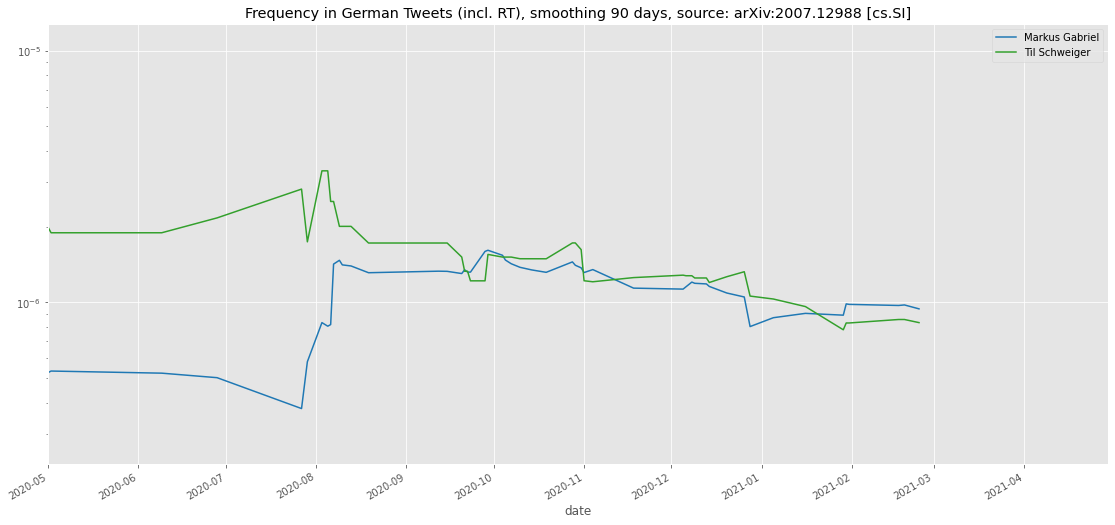

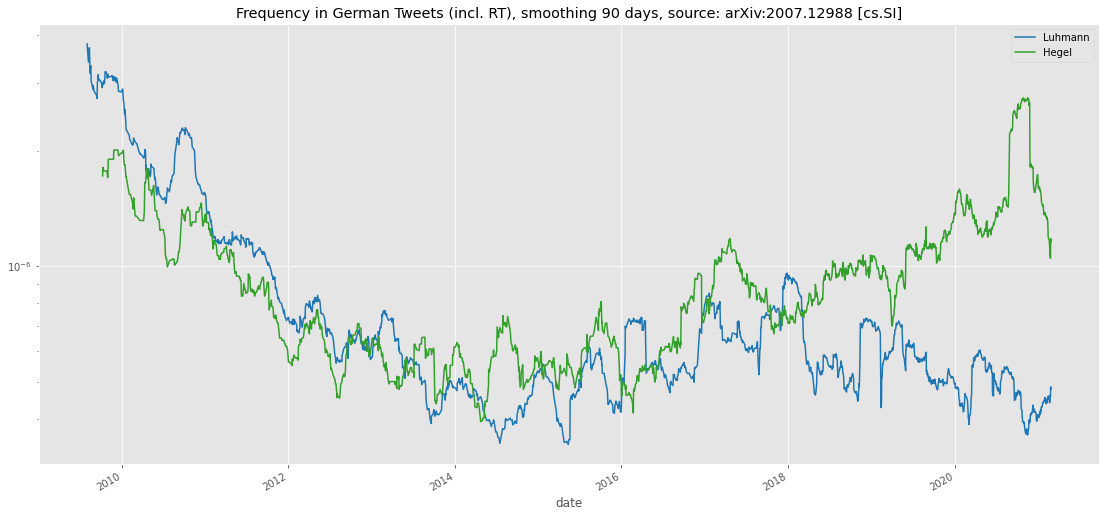

CPU times: user 2.01 s, sys: 65.5 ms, total: 2.08 s
Wall time: 19.3 s


<IPython.core.display.Javascript object>

In [4]:
%%time
frequencies("de", "Markus Gabriel", "Til Schweiger").rolling('90D', min_periods=2).mean().plot(title=f"Frequency in {LONG['de']} Tweets (incl. RT), smoothing 90 days, source: arXiv:2007.12988 [cs.SI]", xlim=['2020-05-01','2021-04-30'], logy=True)
frequencies("de", "Luhmann", "Hegel").rolling('90D', min_periods=2).mean().plot(title=f"Frequency in {LONG['de']} Tweets (incl. RT), smoothing 90 days, source: arXiv:2007.12988 [cs.SI]", logy=True)
plt.show()

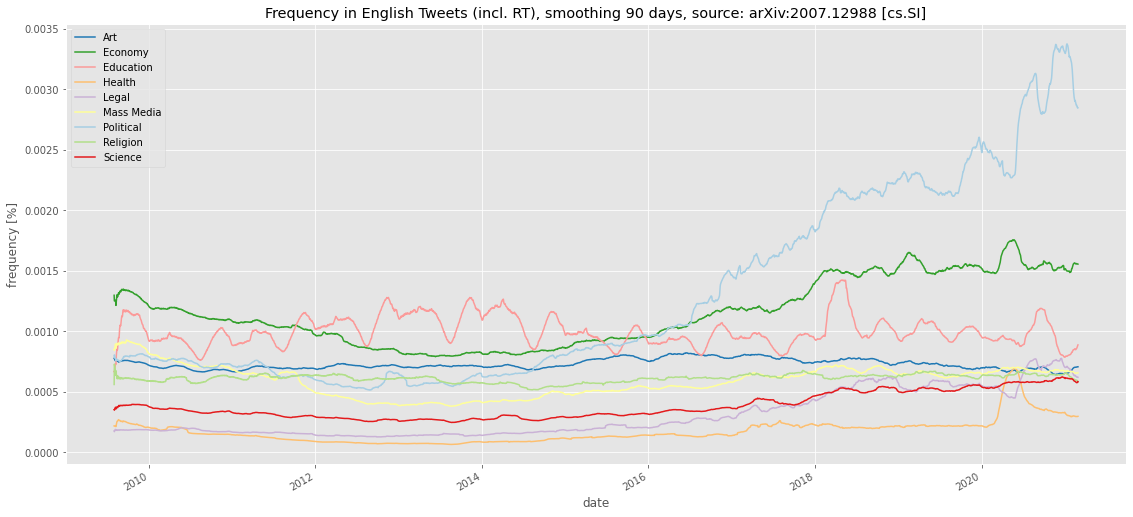

CPU times: user 8.08 s, sys: 414 ms, total: 8.5 s
Wall time: 8min 59s


<IPython.core.display.Javascript object>

In [5]:
%%time
plot_systems("en")
plt.show()

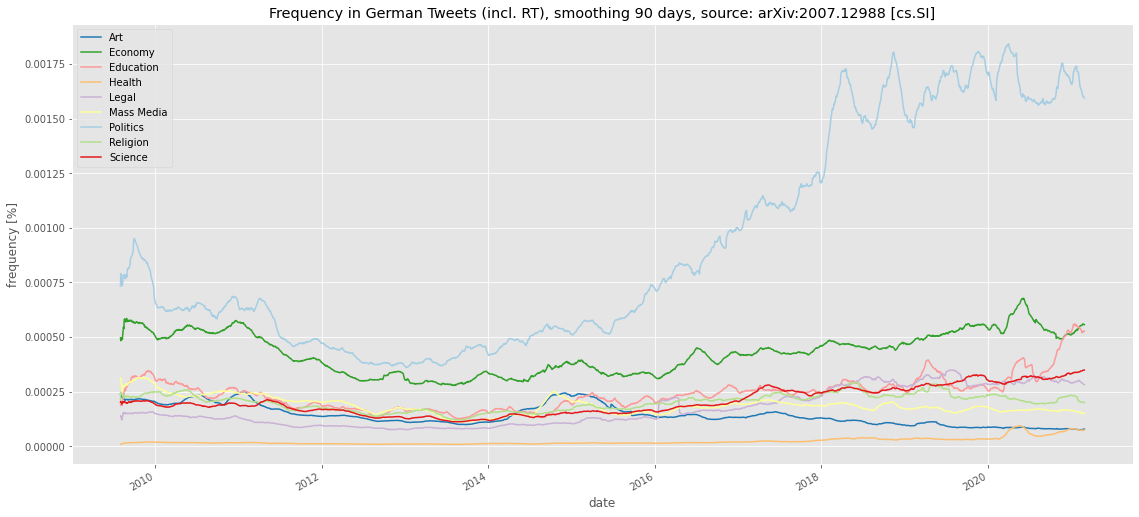

CPU times: user 7.28 s, sys: 344 ms, total: 7.63 s
Wall time: 6min 43s


<IPython.core.display.Javascript object>

In [6]:
%%time
plot_systems("de")
plt.show()

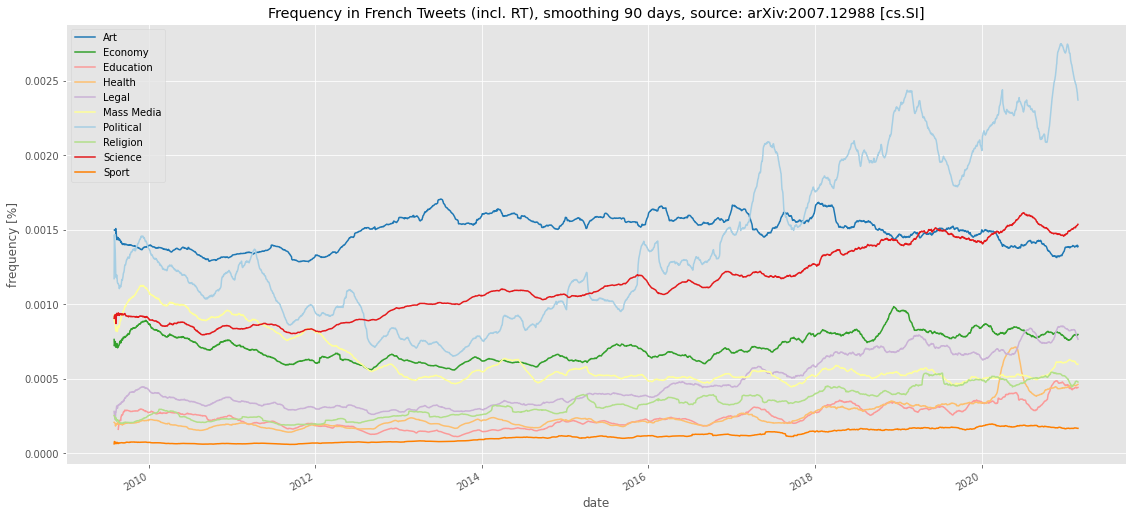

CPU times: user 12.2 s, sys: 635 ms, total: 12.8 s
Wall time: 10min 59s


<IPython.core.display.Javascript object>

In [7]:
%%time
plot_systems("fr")
plt.show()

# Where does the rythm in Education in English tweets come from?

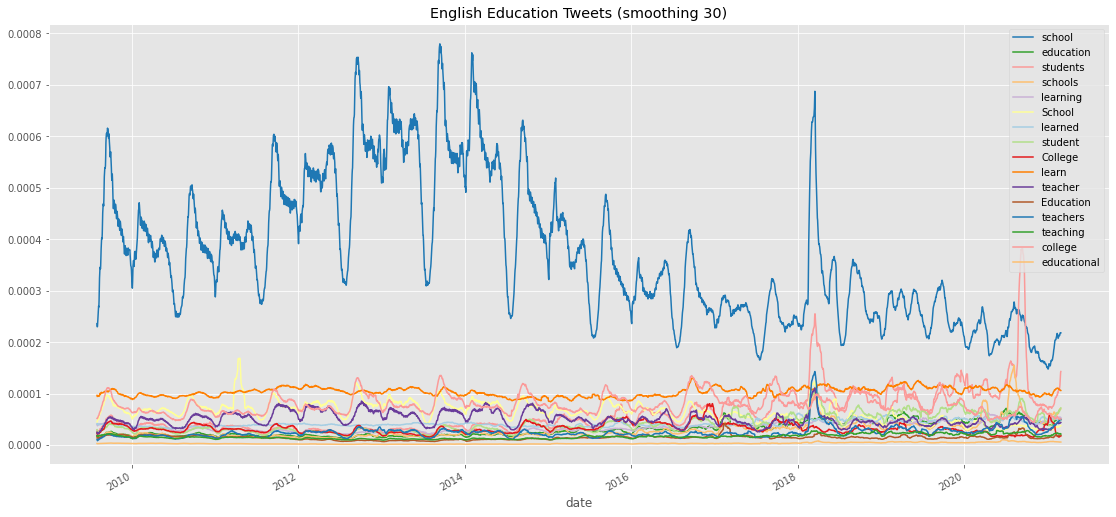

<IPython.core.display.Javascript object>

In [10]:
frequencies("en", *keywords("en")["Education"]).rolling("30D").mean().plot(
    title="English Tweets concerning Education (smoothing 30)"
)
plt.show()